# 통계 기반 기법, Statistical Language Model, SLM

통계를 기반으로 어떤 데이터가 많이 사용되는지 데이터가 어떻게 분포되어 있는지 데이터의 분포에 따라 어떤 연관성과 의미를 갖는 등의 정보를 추출하여 자연어를 처리하는 기법 통계를 사용하므로 통계 결과를 계산하기 위한 충분한 크기를 가진 대규모의 텍스트 데이터가 요구된다. 

## 분포가설 
단어의 의미는 주변 단에 의해 형성, 단어가 사용된 맥락이 의미를 형성한다. 

#### 분포가설을 기초로 문장에서 어떤 단어가 몇번이나 나오는지 count 
* 동시발생 행렬 - 주어진 단어의 맥락으로써 동시에 발생하는 단어의 출현빈도 
* 동시발생 행렬을 이용하여 단어를 벡터로 표현하면 벡터 사이의 유사도를 계산하여 해당 단어 간의 유사도, 괸련성을 확인 가능하다. 
* 유사도 계산 - 내적, 유클리드 거리, 코사인 유사도(많이사용) 

#### 카운트 기반 접근의 한계 희소 문제(Sparsity problem)
언어 모델은 실생활에서 사용되는 언어의 확률 분포를 근사 모델링 한다.기계에게 많은 코퍼스를 훈련시켜서 언어 모델을 통해 현실에서의 확률 분포를 근사하는 것이 언어 모델의 목표이다. 예를 들어 위와 같이 를 구하는 경우에서 기계가 훈련한 코퍼스에 a favorable outcome is라는 단어 시퀀스가 없었다면 이 단어 시퀀스에 대한 확률은 0이 됩니다. a favorable outcome 라는 단어 시퀀스가 없었다면 분모가 0이 되어 확률은 정의되지 않습니다. 그렇다면 코퍼스에 단어 시퀀스가 없다고 해서 이 확률을 0 또는 정의되지 않는 확률이라고 하는 것이 정확한 모델링 방법일까 아니다. 현실에선 favorable outcome  is 라는 단어 시퀀스가 존재하고 또 문법에도 적합하므로 정답일 가능성 또한 높다. 이와 같이 충분한 데이터를 관측하지 못하여 언어를 정확히 모델링하지 못하는 문제를 희소 문제(sparsity problem)라고 한다.

참조 : 딥 러닝을 이용한 자연어 처리 입문 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
text = '요즘 패션업계의 화두는 ‘애슬레저’다. 애슬레저는 애슬레틱(athletic)과 레저(leisure)의 합성어로, 일상복과의 경계를 허문 스포츠웨어를 뜻한다.'
print(text)

In [ ]:
w = text.split(' ')
print(w)

In [ ]:
w_id = {}
id_to_word = {}

for word in w :
  if word not in w_id :
    new_id = len(w_id) 
    w_id[word] = new_id
    id_to_word[new_id] = word

In [ ]:
id_to_word

In [ ]:
w_id 

In [ ]:
# 단어로 id 검색 
print(id_to_word[1])
print(w_id['레저(leisure)의'])

In [ ]:
# "단어 목록"을 "단어 ID 목록"으로 변경

corpus = [w_id[w] for w in w]
corpus = np.array(corpus)
corpus

In [ ]:
import sys

# 지금까지의 과정을 함수로 구현하여 호출하기 편하게 만들자
def preprocess(text):
  text = text.lower()
  text = text.replace('.', ' .')
  words = text.split(' ')

  word_to_id = {}
  id_to_word = {}

  for word in words:
    if word not in word_to_id:
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word

  corpus = np.array([word_to_id[w] for w in words])
  return corpus, word_to_id, id_to_word

In [ ]:
text = "You say goodbye and hello."
corpus, word_to_id, id_to_word =preprocess(text)

print(corpus)
print(id_to_word)

### 분포가설과 동시발생 행렬 

In [ ]:
C = np.array([
              [0, 1, 0, 0, 0, 0, 0],
              [1, 0, 1, 0, 1, 1, 0],
              [0, 1, 0, 1, 0, 0, 0],
              [0, 0, 1, 0, 1, 0, 0],
              [0, 1, 0, 1, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 1],
              [0, 0, 0, 0, 0, 1, 0],
], dtype=np.int32)

In [ ]:
print(C[0])
print(C[4])
print(C[word_to_id['goodbye']])

In [ ]:
# 동시발생 행렬을 만들어주는 함수
def create_co_matrix(corpus, vocab_size, window_size=1):
  corpus_size = len(corpus)
  co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

  for idx, word_id in enumerate(corpus):
    for i in range(1, window_size + 1):
      left_idx = idx - i
      right_idx = idx + i

      if left_idx >= 0:
        left_word_id = corpus[left_idx]
        co_matrix[word_id, left_word_id] += 1

      if right_idx < corpus_size:
        right_word_id = corpus[right_idx]
        co_matrix[word_id, right_word_id] += 1

  return co_matrix

text = "You say goodbye and hello."
corpus, word_to_id, id_to_word =preprocess(text)
vocab_size = len(corpus)
C = create_co_matrix(corpus, vocab_size)
print(C)

### 유사도 측정
- 분모에 eps를 더하는 이유: 인수로 제로벡터가 들어오면 0으로 나누기 오류 발생 --> eps를 더해줌으로써 오류 회피 가능

In [ ]:
# 코사인 유사도 
def cos_similarity(x, y, eps=1e-8):
  nx = x / (np.sqrt(np.sum(x**2)) + eps)    # x의 정규화
  ny = y / (np.sqrt(np.sum(y**2)) + eps)    # y의 정규화
  return np.dot(nx, ny)

In [ ]:
import sys

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word =preprocess(text)
vocab_size = len(corpus)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0, c1))

#### 유사 단어의 랭킹 표시
- 어떤 단어가 주어지면 그 검색어와 비슷한 단어를 유사도 순으로 출력해보기
- most_similar(query, word_to_id, id_to_word, word_matrix, top=5)
  - query: 검색어(단어)
  - word_to_id: 단어에서 단어 ID로의 딕셔너리
  - id_to_word: 단어 ID에서 단어로의 딕셔너리
  - word_matrix: 단어 벡터들을 한데 모은 행렬. 각 행에는 대응하는 단어의 벡터가 저장되어 있다고 가정함
  - top: 상위 몇 개까지 

In [ ]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
  # 검색어의 단어벡터 꺼내기
  if query not in word_to_id:
    print('%s(을)을 찾을 수 없습니다.' % query)
    return
  
  print('\n[query] ' + query)
  query_id = word_to_id[query]
  query_vec = word_matrix[query_id]

  # 검색어의 단어벡터와 다른 모든 단어벡터와의 코사인 유사도를 각각 계산한다
  vocab_size = len(id_to_word)
  similarity = np.zeros(vocab_size)

  for i in range(vocab_size):
    similarity[i] = cos_similarity(word_matrix[i], query_vec)

  # 코사인 유사도를 기준으로 내림차순으로 출력
  count = 0
  for i in (-1 * similarity).argsort():     # argsort(): 넘파이 배열의 원소를 오름차순으로 정렬. 반환값은 배열의 인덱스
    if id_to_word[i] == query:
      continue
    print(' %s: %s' % (id_to_word[i], similarity[i]))

    count += 1
    if count >= top:
      return

In [ ]:
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word =preprocess(text)
vocab_size = len(corpus)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)

### 점별 상호 정보량(Pointwise Mutual Information, PMI)

𝑷𝑴𝑰𝒙,𝒚=𝒍𝒐𝒈2 𝑷(𝒙,𝒚) /𝑷(x) 𝑷(𝒚)

- ppmi 함수: 동시발생 행렬을 PPMI 햏렬로 변환하는 함수
    - C: 동시발생 행렬
    - verbose: 진행상황 출력 여부를 결정하는 플래그
    - eps: np.log2(0)가 음의 무한대가 되는 경우를 피하기 위한 값

In [ ]:
def ppmi(C, verbose=False, eps=1e-8):
  M = np.zeros_like(C, dtype=np.float32)
  N = np.sum(C)
  S = np.sum(C, axis=0)
  total = C.shape[0] * C.shape[1]
  cnt = 0

  for i in range(C.shape[0]):
    for j in range(C.shape[1]):
      pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps)
      M[i, j] = max(0, pmi)

      if verbose:
        cnt += 1
        if cnt % (total //100) == 0:
          print('%.1f%% 완료' % (100 * cnt / total))
      
  return M

In [ ]:
text = "Golden State dominated with a balanced attack and energy on both ends after Green called for the offense to do more to better the defense."
corpus, word_to_id, id_to_word =preprocess(text)
vocab_size = len(corpus)
C = create_co_matrix(corpus, vocab_size)

W = ppmi(C)

np.set_printoptions(precision=3)    # 유효 자릿수를 세 자리로 표시
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

### 차원감소 
벡터의 차원을 줄이는 기법으로  “중요한 정보”는 최대한 유지하면서 줄인다. 
단어 벡터는 주로 원핫 인코딩과 같은 희소벡터(=희소행렬)를 사용하므로 →희소벡터에서 중요한 축을 찾아내어 더 적은 차원으로 다시 표현하는 것이 핵심이다.

* 특잇값 분해(Singular Value Decomposition, SVD)
주어진 행렬(X)을 3개의 행렬(U,S,V)의 곱으로 분해 → 𝑿 = 𝑼𝑺𝑽𝑻
• U, V: 직교행렬(열 벡터가 서로 직교함) → 어떤 공간의 축(기저)을 형성. U행렬은 단어 공간
• S: 대각행렬(대각성분 외에는 모두 0)→대각성분은 특잇값(=해당 축의 중요도) → 중요도가 낮은 원소(특잇값이 작은 원소)를 깎아내어 차원 축소에 반영


 


In [ ]:
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word =preprocess(text)
vocab_size = len(corpus)
C = create_co_matrix(corpus, vocab_size)

W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)      # 넘파이에서 기본적으로 SVD 함수를 제공함

print(C[0])   # 동시발생 행렬
print('-'*50)
print(W[0])   # PPMI 행렬
print('-'*50)
print(U[0])   # SVD
print('-'*50)
print(U[0, :2])

In [ ]:
for word, word_id in word_to_id.items():
  plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()



## 추론 기반 기법 
신경망을 이용한 추론을 기반으로 단어의 분산 표현을 얻는 기법, 통계 기반 기법과 마찬가지로 분포 가설을 기초로 한다. 추론 기반 기법은 학습 데이터의 일부를 사용하여 순차적으로 학습한다.(미니배치 학습)
주변 단어들을 맥락으로 사용하여 문장 중간에 들어갈 단어를 추측하는 추론 문제를 반복 수행하여 단어의 출현 패턴을 학습한다.

* CBOW: 신경망의 입력을 주변 단어들로 구성하고 출력을 타깃 단어로 설정하여 학습된
가중치 데이터를 임베딩 벡터로 활용
* skip-gram: 하나의 타깃 단어를 이용하여 주변 단어들을 예측하는 모델(CBOW와 반대)
 



#### CBOW
- CBOW 모델의 추론 과정
  - CBOW 모델은 활성화 함수를 사용하지 않는 간단한 구성의 신경망 모델

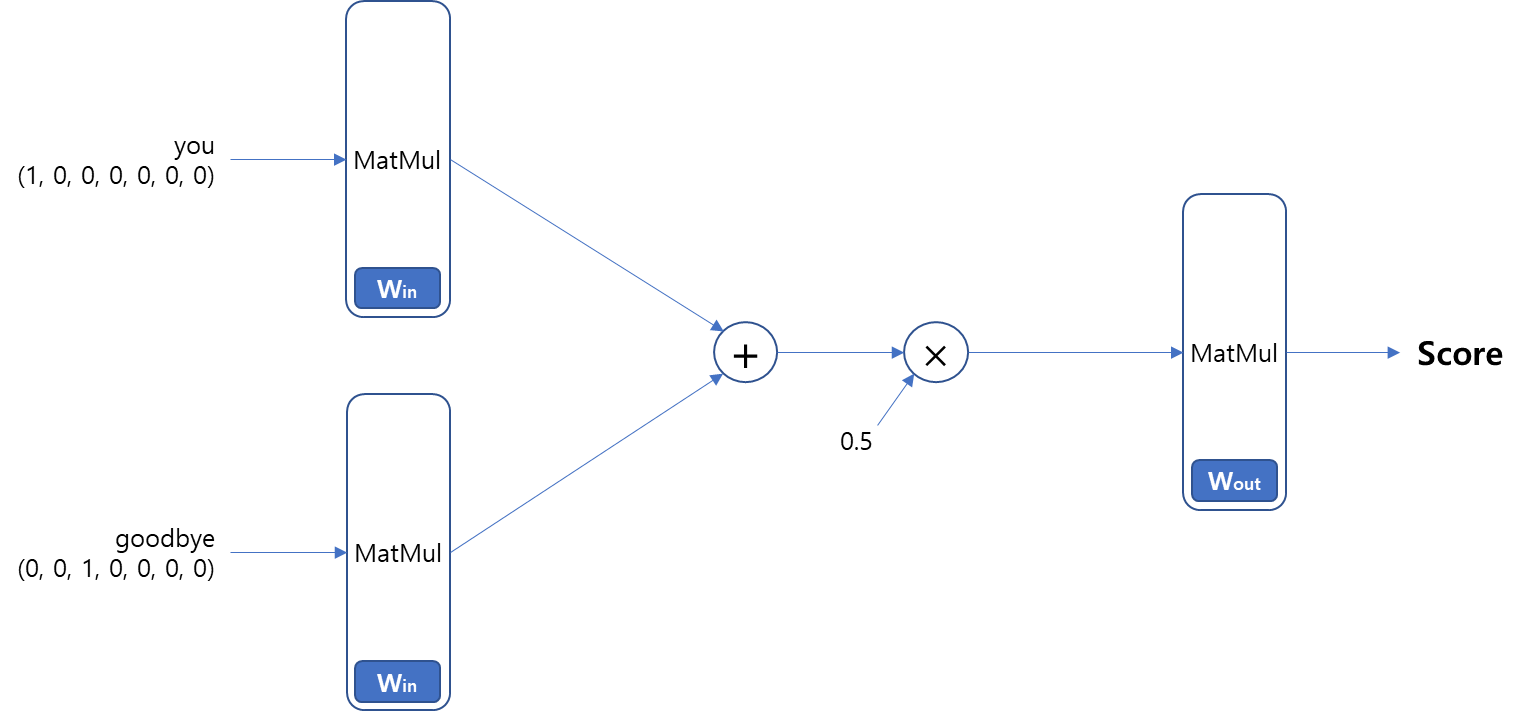

In [ ]:
import numpy as np
from common.layers import MatMul

In [ ]:
# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

# 결과는 각 단어의 점수
print(s)

[[-1.671  0.134  1.397 -0.965 -1.558 -1.344  2.13 ]]


- CBOW 모델의 학습
  - 앞에서 계산한 각 단어의 점수에 Softmax 함수를 적용하여 확률 계산
  - 계산된 확률은 맥락(전후 단어)이 주어졌을때 그 중앙에 어떤 단어가 출현할 것인지에 대한 확률값
  - 신경망 모델의 다중 클래스 분류 신경망을 생각하면 쉽게 이해가 될 것임
  - CBOW 모델에 Softmax 계층과 Cross Entropy Error 계층을 추가함으로써 CBOW 모델의 손실을 계산할 수 있음

- 학습 데이터 준비

In [ ]:
# 전처리
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print('-'*50)
print(id_to_word)

[0 1 2 3 4 1 5 6]
--------------------------------------------------
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [ ]:
# 맥락과 타겟 만들기
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)
print('-'*50)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
--------------------------------------------------
[1 2 3 4 1 5]


In [ ]:
# 원핫 인코딩 표현
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [ ]:
contexts

array([[[1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]],

       [[0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1]]], dtype=int32)

- CBOW 모델 구현

In [ ]:
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

In [ ]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

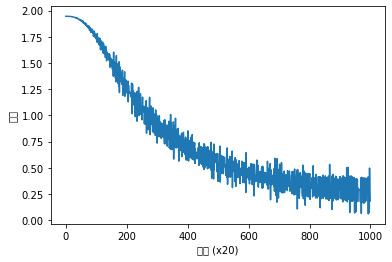

In [ ]:
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [ ]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [ 0.915  0.857 -1.486 -0.81   1.416]
say [-0.243 -1.343 -0.227  1.36   0.193]
goodbye [ 1.247  1.21   0.418 -1.145 -0.214]
and [-1.351 -1.097 -1.264  1.105  1.288]
i [ 1.215  1.206  0.408 -1.147 -0.229]
hello [ 0.915  0.853 -1.488 -0.816  1.426]
. [ 1.56  -1.079  1.251  1.163 -1.256]


#### 2.3.3 skip-gram
- 입력하고자 하는 문자열
  - Duct tape works anywhere. Duct tape is magic and should be worshiped.
  - (덕트 테이프는 어디서나 작동합니다. 덕트 테이프는 마법이며 숭배해야 합니다.)
- 핵심부분만 보기 위하여 사전처리를 직접 정리해 둠
  - 모든 단어의 소문자화: duct tape works anywhere. duct tape is magic and should be worshiped.
  - 의미없는 조동사, be동사, 접속사, 마침표 등을 제거하고 동사는 원형으로 변형: duct tape work anywhere duct tape magic worship
  - 같은 단어 제거: duct tape work anywhere magic worship
  - 최종 결과: ["duct", "tape", "work", "anywhere", "magic", "worship"]
- 하려고 하는 작업
  - "tape"가 주어지면 앞뒤로 어떤 단어가 나올 것인지 추론

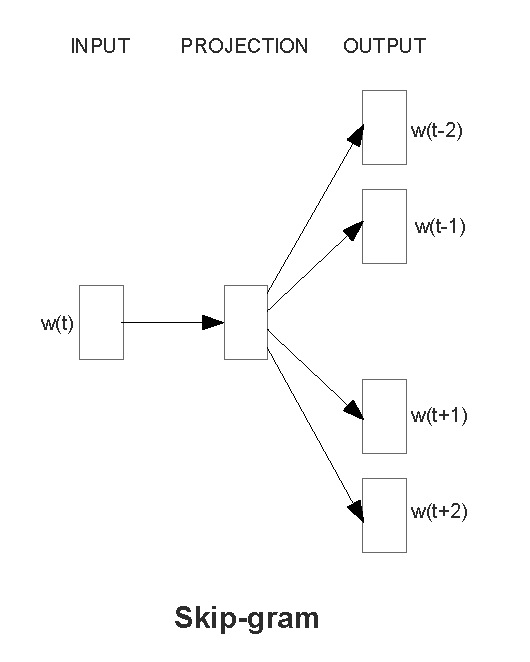

- 가운데의 층을 신경망 모델을 사용해도 되고 단순한 완전연결계층을 이용한 행렬곱을 사용해도 됨
- 데이터가 커질수록 신경망 모델의 효율성, 성능이 높아지며 단순한 예제 데이터의 경우는 행렬곱으로도 충분함

In [ ]:
# Input String : "Duct tape works anywhere. Duct tape is magic and should be worshiped."

v = ["duct", "tape", "work", "anywhere", "magic", "worship"]
print(len(v))
print(v[0])

6
duct


In [ ]:
import numpy as np

In [ ]:
np.random.seed(42)
input_array_tape=np.array([0,1,0,0,0,0]) #"tape"
input_weight_matrix = np.random.random_sample((6,3))
print(input_weight_matrix)

[[0.375 0.951 0.732]
 [0.599 0.156 0.156]
 [0.058 0.866 0.601]
 [0.708 0.021 0.97 ]
 [0.832 0.212 0.182]
 [0.183 0.304 0.525]]


In [ ]:
projection = np.dot(input_array_tape,input_weight_matrix)
print(projection)

[0.599 0.156 0.156]


In [ ]:
output_weight_matrix = np.random.random_sample((3,6))
print(output_weight_matrix)

[[0.432 0.291 0.612 0.139 0.292 0.366]
 [0.456 0.785 0.2   0.514 0.592 0.046]
 [0.608 0.171 0.065 0.949 0.966 0.808]]


In [ ]:
output_array_for_input_tape_and_orange_output_context = np.dot(projection, output_weight_matrix)
print(output_array_for_input_tape_and_orange_output_context)

[0.425 0.323 0.408 0.312 0.418 0.353]


In [ ]:
print(list(zip(v, output_array_for_input_tape_and_orange_output_context)))

[('duct', 0.42451663675598933), ('tape', 0.3234497105099373), ('work', 0.4075914505752598), ('anywhere', 0.3117602853605092), ('magic', 0.41795589389125587), ('worship', 0.35267831257488347)]


- 가장 높은 추론값을 가지는 것은
  1. duct (0.4245)
  2. magic (0.4179)
  3. work (0.4075)
<br><br>
- 주어진 문장: *duct* **tape** *work* anywhere *duct* **tape** *magic* worship